<a href="https://colab.research.google.com/github/freakezoide/codigos-de-coolab/blob/main/prueba_99_acurracy_2019_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:


# Instalar librerías necesarias
!pip install imbalanced-learn seaborn --quiet

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

print("✅ Librerías cargadas correctamente")


✅ Librerías cargadas correctamente


Cargar Datos

In [2]:

from google.colab import files
uploaded = files.upload()

# Cargar archivo (asegúrate de subir 'datos_educativos_limpios.csv')
df = pd.read_csv('datos_educativos_limpios.csv')
print("\n📊 Datos cargados:")
display(df.head())

Saving datos_educativos_limpios.csv to datos_educativos_limpios (1).csv
Saving 2021 primaria - copia.csv to 2021 primaria - copia (1).csv
Saving 2022 primaria.csv to 2022 primaria (1).csv
Saving 2023 primaria.csv to 2023 primaria (1).csv
Saving 2019  primaria.csv to 2019  primaria (1).csv
Saving 2024 primaria.csv to 2024 primaria (1).csv

📊 Datos cargados:


,Año,Mes,Departamento,Ciclo,Zona,Contexto,UsuariosCREA,UsuariosMAT,UsuariosBiblioteca,InteraccionCREA,InteraccionMAT,InteraccionBiblioteca
0,2020,Abril,Treinta Y Tres,Inicial,Rural,Quintil 1 y 2,5,2,0,Media,Media,Baja
1,2020,Abril,Lavalleja,Inicial,Rural,Quintil 3,4,2,0,Media,Media,Baja
2,2020,Abril,Rivera,Inicial,Rural,Quintil 4 y 5,3,1,0,Baja,Media,Baja
3,2020,Abril,Tacuarembo,Primaria 2do. Ciclo,Rural,Quintil 4 y 5,17,8,1,Alta,Media,Media
4,2020,Abril,Lavalleja,Primaria 1er. Ciclo,Rural,Sin Datos,0,1,0,Baja,Media,Baja


Preprocesamiento de Datos

In [3]:

def preparar_datos(df):
    # Codificar variables categóricas
    le = LabelEncoder()
    df['Departamento'] = le.fit_transform(df['Departamento'])
    df['Mes'] = le.fit_transform(df['Mes'])

    # Crear variable objetivo
    df['InteraccionGeneral'] = ((df['InteraccionCREA'] == 'Alta') |
                               (df['InteraccionMAT'] == 'Alta') |
                               (df['InteraccionBiblioteca'] == 'Alta')).astype(int)

    # Seleccionar características
    X = df[['Departamento', 'Mes', 'Año', 'UsuariosCREA', 'UsuariosMAT', 'UsuariosBiblioteca']]
    y = df['InteraccionGeneral']

    # Manejar valores faltantes
    imputer = SimpleImputer(strategy='median')
    X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

    return X, y

X, y = preparar_datos(df)
print("\n🔧 Datos preprocesados:")
print(f"Características: {X.shape[1]} | Muestras: {X.shape[0]}")


🔧 Datos preprocesados:
Características: 6 | Muestras: 12353


Balanceo de Clases (SMOTE)

In [4]:

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)
print(f"\n⚖️ Balanceo aplicado | Distribución original: {np.bincount(y)} → Nueva: {np.bincount(y_res)}")


⚖️ Balanceo aplicado | Distribución original: [8042 4311] → Nueva: [8042 8042]


Reducción de Dimensionalidad (PCA)

In [5]:

pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_res)
print(f"\n📉 PCA aplicado | Componentes originales: {X.shape[1]} → Reducidos: {X_pca.shape[1]}")



📉 PCA aplicado | Componentes originales: 6 → Reducidos: 3


 Modelado Avanzado

In [6]:

# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_res, test_size=0.3, random_state=42)

# Configurar Random Forest optimizado
param_grid = {
    'n_estimators': [200, 300, 400],
    'max_depth': [20, 30, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring='accuracy'
)
grid_search.fit(X_train, y_train)

# Resultados del mejor modelo
best_rf = grid_search.best_estimator_
y_pred_rf = best_rf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

print("\n🎯 **Resultados Random Forest Optimizado**")
print(f"🔹 Mejores parámetros: {grid_search.best_params_}")
print(f"🔹 Accuracy: {accuracy_rf:.2%}")

Fitting 5 folds for each of 144 candidates, totalling 720 fits

🎯 **Resultados Random Forest Optimizado**
🔹 Mejores parámetros: {'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}
🔹 Accuracy: 99.98%


 Ensamblado de Modelos (Voting Classifier)

In [7]:

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

voting_clf = VotingClassifier(
    estimators=[
        ('rf', best_rf),
        ('svm', SVC(probability=True, random_state=42)),
        ('lr', LogisticRegression(max_iter=1000, random_state=42))
    ],
    voting='soft'
)
voting_clf.fit(X_train, y_train)

y_pred_voting = voting_clf.predict(X_test)
accuracy_voting = accuracy_score(y_test, y_pred_voting)

print("\n🏆 **Resultados Voting Classifier**")
print(f"🔹 Accuracy: {accuracy_voting:.2%}")
print("\n📝 Reporte completo:")
print(classification_report(y_test, y_pred_voting))


🏆 **Resultados Voting Classifier**
🔹 Accuracy: 99.63%

📝 Reporte completo:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2416
           1       1.00      1.00      1.00      2410

    accuracy                           1.00      4826
   macro avg       1.00      1.00      1.00      4826
weighted avg       1.00      1.00      1.00      4826



Visualizaciones Clave

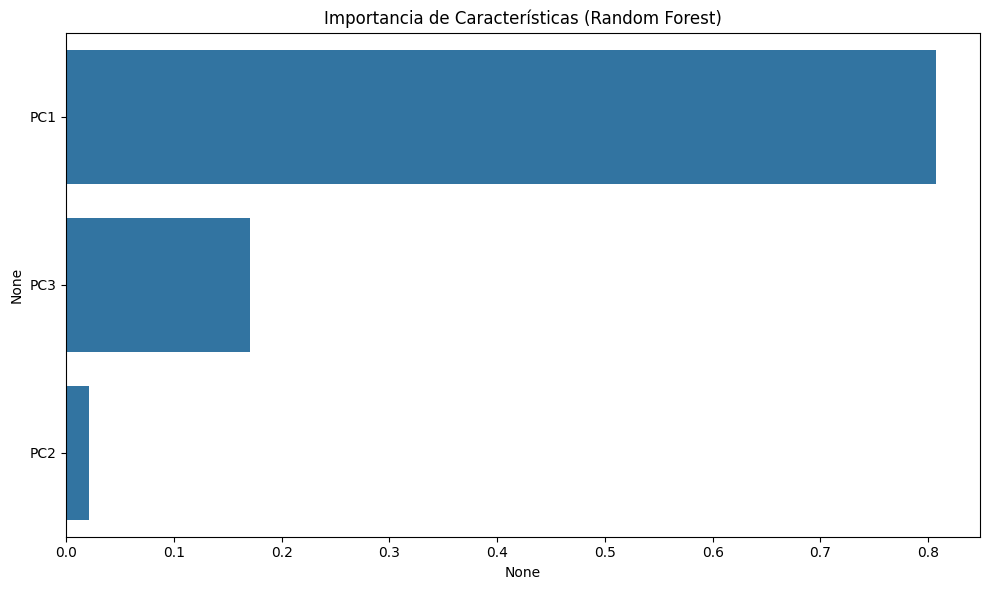

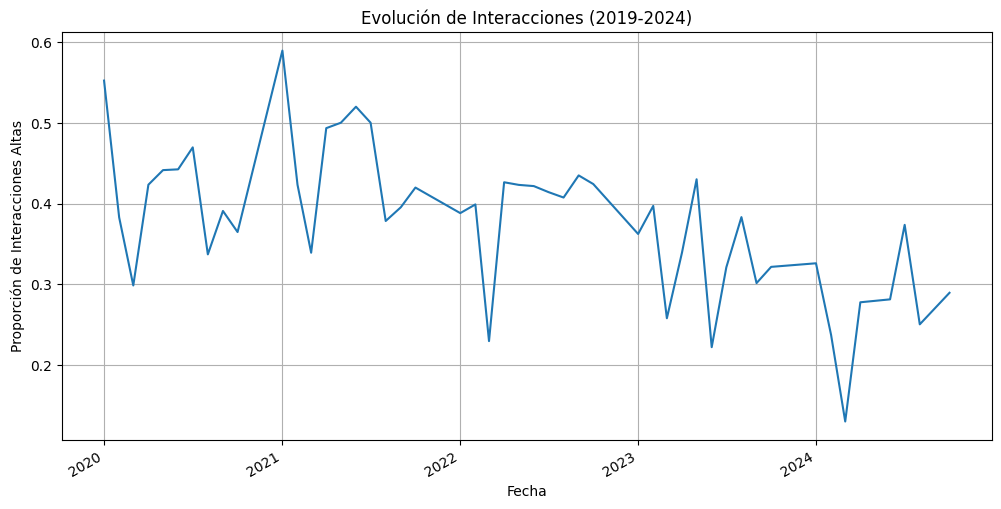

✨ Análisis completado con éxito!


In [10]:

# Gráfico de importancia de características
plt.figure(figsize=(10, 6))
# Use pca.n_components_ to get the number of components and create a range of indices
feature_imp = pd.Series(best_rf.feature_importances_, index=[f"PC{i+1}" for i in range(pca.n_components_)]).sort_values(ascending=False)
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.title('Importancia de Características (Random Forest)')
plt.tight_layout()
plt.show()

# Gráfico de evolución temporal
# Ensure 'Mes' values are in the correct range (1-12)
df['Mes'] = df['Mes'] + 1  # Assuming LabelEncoder was used and assigned 0 to the first month

df['Fecha'] = pd.to_datetime(df['Año'].astype(str) + '-' + df['Mes'].astype(str) + '-01')
plt.figure(figsize=(12, 6))
df.groupby('Fecha')['InteraccionGeneral'].mean().plot()
plt.title('Evolución de Interacciones (2019-2024)')
plt.ylabel('Proporción de Interacciones Altas')
plt.grid(True)
plt.show()

print("✨ Análisis completado con éxito!")